# Capstone Project

## The Battle of Neighborhoods

### Cultural Similarities
 *Christopher Neal*
 
 ***

## Import Libaries

In [24]:
import pandas as pd
import numpy as np
import requests
import folium
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

## Foursquare ID

In [2]:
CLIENT_ID = 'HOCKKNRUKYFIFJKAS35RM50FICJ13FBOZHJSTGCFXX5NPD4C' #  Foursquare ID
CLIENT_SECRET = 'WPWAZ3ZCW3ENQAYIF0CJGVOMONT1QFNJ3GLZ5MWDL1I50Q1D' #  Foursquare Secret
VERSION = '20180605' # Foursquare API version

## Functions

In [3]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except KeyError:
            pass
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## Reading datasets

In [4]:
#Previously compiled toronto venues
toronto_venue = pd.read_csv(r'C:\Users\TrustyKarma\github\Projects\Coursera_Capstone\assets\toronto_venues.csv')

# New York Datset
ny_data = get_new_york_data()

In [5]:
ny_data

Borough  Neighborhood   Latitude  Longitude
0            Bronx     Wakefield  40.894705 -73.847201
1            Bronx    Co-op City  40.874294 -73.829939
2            Bronx   Eastchester  40.887556 -73.827806
3            Bronx     Fieldston  40.895437 -73.905643
4            Bronx     Riverdale  40.890834 -73.912585
..             ...           ...        ...        ...
301      Manhattan  Hudson Yards  40.756658 -74.000111
302         Queens       Hammels  40.587338 -73.805530
303         Queens     Bayswater  40.611322 -73.765968
304         Queens  Queensbridge  40.756091 -73.945631
305  Staten Island     Fox Hills  40.617311 -74.081740

[306 rows x 4 columns]

In [6]:
ny_venues = getNearbyVenues(names=ny_data['Neighborhood'],
                                   latitudes=ny_data['Latitude'],
                                   longitudes=ny_data['Longitude']
                                  )

In [7]:
#saving dataframe to csv
#ny_venues.to_csv (r'C:\Users\TrustyKarma\github\Projects\Coursera_Capstone\assets\ny_venues.csv', index = False, header=True)

The number of venues is quite large lets simplify to culural venues

In [8]:
print(ny_venues['Venue Category'].unique())

['Dessert Shop' 'Pharmacy' 'Ice Cream Shop' 'Donut Shop' 'Gas Station'
 'Sandwich Place' 'Deli / Bodega' 'Laundromat' 'Pizza Place'
 'Discount Store' 'Post Office' 'Bagel Shop' 'Grocery Store'
 'Fast Food Restaurant' 'Restaurant' 'Baseball Field'
 'Fried Chicken Joint' 'Salon / Barbershop' 'Gift Shop' 'Bus Station'
 'Basketball Court' 'Park' 'Diner' 'Caribbean Restaurant'
 'Seafood Restaurant' 'Chinese Restaurant' 'Bowling Alley'
 'Automotive Shop' 'Food & Drink Shop' 'Platform' 'Metro Station'
 'Convenience Store' 'Bus Stop' 'Cosmetics Shop' 'Plaza' 'River' 'Bank'
 'Moving Target' 'Locksmith' 'Food Truck' 'Gym' 'Playground'
 'Gourmet Shop' 'Latin American Restaurant' 'Burger Joint' 'Pub'
 'Spanish Restaurant' 'Beer Bar' 'Warehouse Store' 'Coffee Shop'
 'Mexican Restaurant' 'Bar' 'Wings Joint' 'Trail' 'Supermarket'
 'Thrift / Vintage Store' 'Bakery' 'Candy Store' 'Café' 'Breakfast Spot'
 'Rental Car Location' 'Supplement Shop' 'Mattress Store' 'Pet Store'
 'Shipping Store' 'Sports Bar'

Obvious cultural venues
* Restaurant (contains word)
* Museum (contains word)
* Music (contains word)
* Historic Site
* Theater (contains word)
* Club (contains word)
* Other Nightlife
* Opera House
* Bar (contains word)

Create a funtion to find the obvious cultural venues

In [9]:
def getCulturalVenues (venues):
     
    #Finding Venues
    restaurant = venues[venues['Venue Category'].str.contains("Restaurant")]
    museum = venues[venues['Venue Category'].str.contains("Museum")]
    music = venues[venues['Venue Category'].str.contains("Music")]
    historic = venues[venues['Venue Category'].str.contains("Historic Site")]
    club = venues[venues['Venue Category'].str.contains("Club")]
    nightlife = venues[venues['Venue Category'].str.contains("Other Nightlife")]
    opera = venues[venues['Venue Category'].str.contains("Opera House")]
    bar = venues[venues['Venue Category'].str.contains("Bar")]
    
    #Creating Dataframe
    culture = pd.concat([restaurant,museum,music,historic,club,nightlife,opera,bar])
    
    return culture

## New York Dataset

In [10]:
ny_culture = getCulturalVenues(ny_venues)

In [11]:
ny_culture['Venue Category'].unique()

array(['Fast Food Restaurant', 'Restaurant', 'Caribbean Restaurant',
       'Seafood Restaurant', 'Chinese Restaurant',
       'Latin American Restaurant', 'Spanish Restaurant',
       'Mexican Restaurant', 'Asian Restaurant', 'Italian Restaurant',
       'Indian Restaurant', 'American Restaurant', 'Sushi Restaurant',
       'French Restaurant', 'Tapas Restaurant', 'African Restaurant',
       'Greek Restaurant', 'Puerto Rican Restaurant',
       'Peruvian Restaurant', 'South American Restaurant',
       'Southern / Soul Food Restaurant', 'Middle Eastern Restaurant',
       'Arepa Restaurant', 'Eastern European Restaurant',
       'Japanese Restaurant', 'Thai Restaurant', 'Cuban Restaurant',
       'Comfort Food Restaurant', 'Caucasian Restaurant',
       'New American Restaurant', 'Vietnamese Restaurant',
       'Dim Sum Restaurant', 'Shabu-Shabu Restaurant',
       'Hotpot Restaurant', 'Polish Restaurant', 'Szechuan Restaurant',
       'Vegetarian / Vegan Restaurant', 'Mediterranean 

In [12]:
ny_culture.shape

(3210, 7)

In [13]:
ny_culture['Venue Category'].describe()

count                   3210
unique                   123
top       Italian Restaurant
freq                     314
Name: Venue Category, dtype: object

## Toronto Dataset

In [14]:
print(toronto_venue['Venue Category'].unique())

['Bakery' 'Coffee Shop' 'Distribution Center' 'Restaurant' 'Spa' 'Park'
 'Pub' 'Historic Site' 'Breakfast Spot' 'Gym / Fitness Center'
 'Farmers Market' 'Chocolate Shop' 'Performing Arts Venue' 'Dessert Shop'
 'Mexican Restaurant' 'Theater' 'French Restaurant' 'Café' 'Yoga Studio'
 'Event Space' 'Shoe Store' 'Ice Cream Shop' 'Art Gallery'
 'Cosmetics Shop' 'Electronics Store' 'Bank' 'Beer Store' 'Hotel'
 'Wine Shop' 'Antique Shop' 'Portuguese Restaurant' 'Italian Restaurant'
 'Beer Bar' 'Sushi Restaurant' 'Persian Restaurant' 'Creperie'
 'Arts & Crafts Store' 'Hobby Shop' 'Diner' 'Fried Chicken Joint'
 'Chinese Restaurant' 'Smoothie Shop' 'Sandwich Place' 'Gym'
 'College Auditorium' 'Bar' 'Music Venue' 'Clothing Store' 'Comic Shop'
 'Pizza Place' 'Plaza' 'Burrito Place' 'Movie Theater' 'Thai Restaurant'
 'Burger Joint' 'Shopping Mall' 'Sporting Goods Shop'
 'New American Restaurant' 'Japanese Restaurant' 'Gastropub'
 'Fast Food Restaurant' 'Tanning Salon' 'Ramen Restaurant' 'Steakhouse

In [15]:
toronto_culture = getCulturalVenues(toronto_venue)

In [16]:
toronto_culture['Venue Category'].unique()

array(['Restaurant', 'Mexican Restaurant', 'French Restaurant',
       'Portuguese Restaurant', 'Italian Restaurant', 'Sushi Restaurant',
       'Persian Restaurant', 'Chinese Restaurant', 'Thai Restaurant',
       'New American Restaurant', 'Japanese Restaurant',
       'Fast Food Restaurant', 'Ramen Restaurant',
       'Middle Eastern Restaurant', 'Modern European Restaurant',
       'Seafood Restaurant', 'Ethiopian Restaurant',
       'Vietnamese Restaurant', 'American Restaurant',
       'Latin American Restaurant', 'Vegetarian / Vegan Restaurant',
       'German Restaurant', 'Comfort Food Restaurant', 'Asian Restaurant',
       'Moroccan Restaurant', 'Belgian Restaurant', 'Greek Restaurant',
       'Indian Restaurant', 'Falafel Restaurant', 'Korean Restaurant',
       'Colombian Restaurant', 'Brazilian Restaurant',
       'Mediterranean Restaurant', 'Gluten-free Restaurant',
       'Cuban Restaurant', 'Malay Restaurant', 'Caribbean Restaurant',
       'Dim Sum Restaurant', 'Cajun 

In [17]:
toronto_culture.shape

(509, 7)

In [18]:
toronto_culture['Venue Category'].describe()

count            509
unique            65
top       Restaurant
freq              54
Name: Venue Category, dtype: object

Comparing the dataset New york has a much greater number of cultural venues, the biggest outlier being Italian restraunts.

## Compare the cities by neighborhood

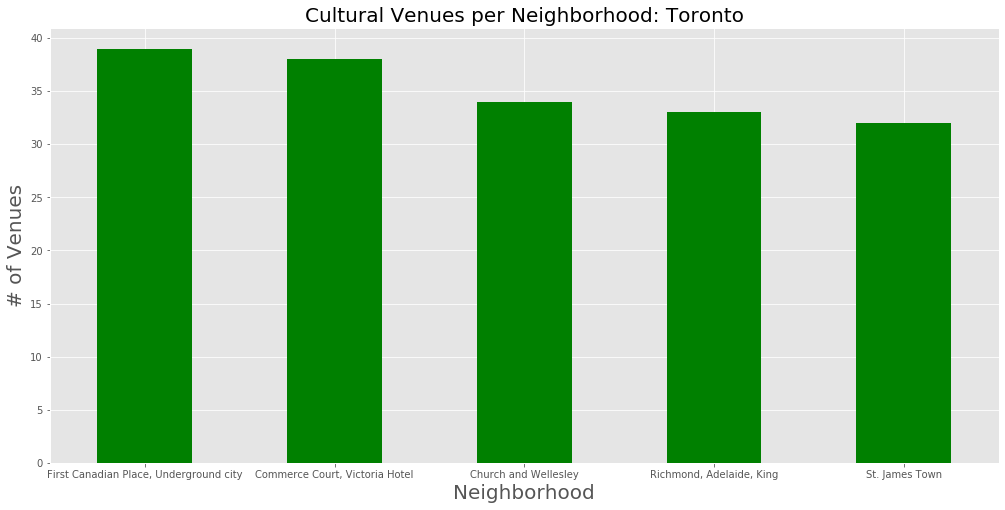

In [19]:
plt.style.use('ggplot')
top_five = 5 # Top 5 neighborhoods
toronto_culture.groupby('Neighborhood')['Venue'].count().nlargest(top_five).plot.bar(figsize=(17,8), color='g')
plt.title('Cultural Venues per Neighborhood: Toronto', fontsize=20)
plt.xlabel("Neighborhood", fontsize=20)
plt.ylabel("# of Venues", fontsize=20)
plt.xticks(rotation = 'horizontal')
plt.show()

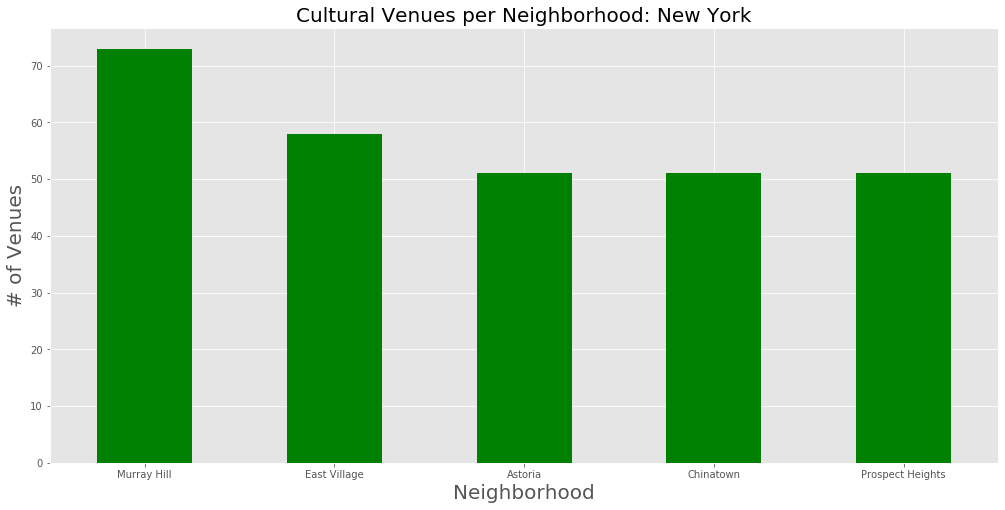

In [20]:
ny_culture.groupby('Neighborhood')['Venue'].count().nlargest(top_five).plot.bar(figsize=(17,8), color='g')
plt.title('Cultural Venues per Neighborhood: New York', fontsize=20)
plt.xlabel("Neighborhood", fontsize=20)
plt.ylabel("# of Venues", fontsize=20)
plt.xticks(rotation = 'horizontal')
plt.show()

New york has a higher number of cultural venues in every neighborhood when compared to the neighborhood of toronto

## Visualizing Cultural Hot Spots

Toronto

In [54]:
#Create map
toronto_map = map_clusters = folium.Map(location=[43.6532, -79.3832], zoom_start=12)

#Create a feature group
feature = folium.map.FeatureGroup()

#Create and style markers
for lat, lng, loc in toronto_culture[['Venue Latitude','Venue Longitude','Venue']].values:
    label = folium.Popup(str(loc), parse_html=True)
    feature.add_child(
        folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='b',
        fill=True,
        fill_color='blue',
        fill_opacitiy=0.6
        )
    )

#add markers to map
toronto_map.add_child(feature)

New York

In [58]:
#Create map
ny_map = map_clusters = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

#Create a feature group
feature = folium.map.FeatureGroup()

#Create and style markers
for lat, lng, loc in ny_culture[['Venue Latitude','Venue Longitude','Venue']].values:
    label = folium.Popup(str(loc), parse_html=True)
    feature.add_child(
        folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='b',
        fill=True,
        fill_color='blue',
        fill_opacitiy=0.6
        )
    )

#add markers to map
ny_map.add_child(feature)